In [22]:
from __future__ import annotations

import requests
import os
import json
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor

from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from matplotlib import pyplot as plt
import faiss
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [23]:
data_path = '/Users/jsb/repos/moodboard/gist_app/data/asos/all_products.json'

In [24]:
import json

with open(data_path, 'r') as fp:
    products = json.loads(fp.readline())

In [25]:
products[0]

{'id': 200604040,
 'name': 'Mango short sleeve maxi dress in black',
 'price': {'current': {'value': 29.0, 'text': '$29.00'},
  'previous': {'value': None, 'text': ''},
  'rrp': {'value': 48.0, 'text': '$48.00'},
  'isMarkedDown': False,
  'isOutletPrice': True,
  'currency': 'USD'},
 'colour': 'Black',
 'colourWayId': 200604041,
 'brandName': 'Mango',
 'hasVariantColours': False,
 'hasMultiplePrices': False,
 'groupId': None,
 'productCode': 105018995,
 'productType': 'Product',
 'url': 'mango/mango-short-sleeve-maxi-dress-in-black/prd/200604040?clr=black&colourWayId=200604041',
 'imageUrl': 'images.asos-media.com/products/mango-short-sleeve-maxi-dress-in-black/200604040-1-black',
 'additionalImageUrls': ['images.asos-media.com/products/mango-short-sleeve-maxi-dress-in-black/200604040-2',
  'images.asos-media.com/products/mango-short-sleeve-maxi-dress-in-black/200604040-3',
  'images.asos-media.com/products/mango-short-sleeve-maxi-dress-in-black/200604040-4'],
 'videoUrl': 'video.asos

In [26]:
# tweaked from https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPModel.forward.returns

# below is standard CLIP usage to score text snippets against a photo

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
def images_to_embeddings(images: list[Image]) -> torch.tensor:
    """"""
    vinput = processor(images=images, return_tensors="pt")

    voutput = model.vision_model(
        **vinput
    )

    vembeds = voutput[1]

    vembeds = model.visual_projection(vembeds)

    vembeds = vembeds / vembeds.norm(p=2, dim=-1, keepdim=True)
    
    return vembeds

In [173]:
def text_to_embeddings(text: list[str]) -> torch.tensor:
    tinput = processor(text=text, padding=True, return_tensors="pt")
    tembeds = model.text_model(**tinput)[1]
    tembeds = model.text_projection(tembeds)
    tembeds = tembeds / tembeds.norm(p=2, dim=-1, keepdim=True) 
    return tembeds

In [175]:
class AsosClothingDataset(Dataset):
    """
    dataset found at https://data.world/promptcloud/amazon-fashion-products-2020/file/marketing_sample_for_amazon_com-amazon_fashion_products__20200201_20200430__30k_data.ldjson
    downloads dataset images fast with multithreading, and includes 
    category-specific subsetting for fast recommendation over a category
    """
    @staticmethod
    def read_records(fpath):
        records = []
        with open(fpath, 'r') as fp:
            for line in fp:
                records.append(json.loads(line))
        return records
    
    def _download(self, record):
        """download a single record"""
        md = None
        try:
            image_url = "https://" + record["imageUrl"]
            image_path = os.path.join(self.image_dir, str(record["id"]) + ".jpg")
            if not os.path.exists(image_path):
                image = Image.open(requests.get(image_url, stream=True).raw)
                image.save(image_path)

            label = f"a catalog photo of {record['name']}"
            
            category = "dress"

            md = {
                "product_id": record["id"],
                "image_path": image_path,
                "image_url": image_url,
                "label": label,
                "category": category,
            }
        except:
            print('failed')
            md = None

        return md

    @staticmethod
    def _thread_run(f, my_iter):
        """download all records using multithreading"""
        with ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(f, my_iter), total=len(my_iter)))
        return results


    def __init__(self, image_dir: str, records: List[dict]):
        
        ids = [rec["id"] for rec in records]
        
        self.image_dir = image_dir
        
        os.makedirs(self.image_dir, exist_ok=True)
        
        # download images and return metadata
#         mds = []
#         for record in records:
#             md = self._download(record)
#             mds.append(md)
        
        mds = self._thread_run(self._download, records)
        mds = [md for md in mds if md is not None]
    
        self.metadata = pd.DataFrame(mds)
        self.metadata.set_index("product_id")
        self.metadata.sort_index()
        self.metadata.reset_index(drop=True)
        
    def __getitem__(self, idx: int) -> (Image, str, str):
        md = self.metadata.iloc[idx]
        
        try:
            image = Image.open(md.image_path)
        except:
            image = None

        return (image, md.label, md.category)
    
    def __len__(self,) -> int:
        return len(self.metadata)
    
    
    def get_category_indices(self, category: str) -> np.array:
        """return the indices of all products in this category"""
        md = self.metadata[self.metadata.category == category]
        return md.index

In [176]:
image_dir = "./TEST"

records = products

asos_dataset = AsosClothingDataset(image_dir=image_dir, records=records)

100%|███████████████████████████████████████████████████████████████████████████████████| 19545/19545 [00:00<00:00, 138671.15it/s]


In [161]:
ls TEST

10125149.jpg         202710160.jpg        203913553.jpg
10132190.jpg         202710600.jpg        203913563.jpg
10645760.jpg         202711185.jpg        203914274.jpg
10663593.jpg         202711468.jpg        203914336.jpg
11491196.jpg         202711529.jpg        203914354.jpg
11931733.jpg         202711575.jpg        203914369.jpg
12074317.jpg         202711752.jpg        203914370.jpg
12285034.jpg         202711762.jpg        203914462.jpg
12570862.jpg         202711873.jpg        203914585.jpg
12572221.jpg         202711909.jpg        203914785.jpg
12926569.jpg         202711916.jpg        203914956.jpg
12989857.jpg         202712553.jpg        203914963.jpg
13108921.jpg         202712573.jpg        203914970.jpg
13140233.jpg         202715299.jpg        203914977.jpg
13244747.jpg         202716033.jpg        203914984.jpg
13245362.jpg         202716291.jpg        203914991.jpg
13706482.jpg         202716409.jpg        203915011.jpg
13787271.jpg         202716433.jpg        203915

200981516.jpg        202805024.jpg        203999943.jpg
200981748.jpg        202805577.jpg        204000842.jpg
200982138.jpg        202805596.jpg        204000943.jpg
200984425.jpg        202805611.jpg        204000945.jpg
200984656.jpg        202805619.jpg        204000960.jpg
200984783.jpg        202805620.jpg        204000991.jpg
200985291.jpg        202805628.jpg        204001540.jpg
200985451.jpg        202805636.jpg        204003352.jpg
200985469.jpg        202805644.jpg        204003432.jpg
200985898.jpg        202805659.jpg        204003486.jpg
200986296.jpg        202805667.jpg        204003488.jpg
200990699.jpg        202805675.jpg        204003526.jpg
200992095.jpg        202807439.jpg        204003534.jpg
200992578.jpg        202807459.jpg        204003550.jpg
200992629.jpg        202807526.jpg        204003559.jpg
200992761.jpg        202807573.jpg        204003582.jpg
200992996.jpg        202807626.jpg        204003598.jpg
200993893.jpg        202808349.jpg        204003

In [162]:
len(asos_dataset.metadata)

19545

# pre-calculate embeddings for all dataset products

In [163]:
def collate_fn(batch):
    images, labels, categories = [], [], []
    for item in batch:
        image, label, category = item
        # filter out any datapoints with corrupt images
        if image is not None:
            images.append(image)
            labels.append(label)
            categories.append(category)
    return images, labels, categories


data_loader = DataLoader(
    dataset = asos_dataset,
    collate_fn = collate_fn,
    batch_size = 32,
    shuffle = False,
)

In [164]:
os.remove(embeddings_path)

In [177]:
embeddings_path = os.path.join(image_dir, 'asos_embeddings.npy')

if not os.path.exists(embeddings_path):
    candidate_vembeds = []

    count = 0
    for imgs, labs, cats in tqdm(data_loader):
        count += len(imgs)
        with torch.no_grad():
            candidate_vembeds.append(images_to_embeddings(imgs))

    candidate_vembeds = torch.concat(candidate_vembeds)
    candidate_vembeds = candidate_vembeds.detach().numpy()
    np.save(embeddings_path, candidate_vembeds)

candidate_vembeds = np.load(embeddings_path)

# search over a category in the dataset

In [185]:
dress_embed = text_to_embeddings(["lady in a dress"]).t()

dists = candidate_vembeds @ dress_embed.detach().numpy()

0.16996875

In [224]:
a = torch.randn(512)
# torch.zeros_like(a).shape

torch.zeros(512).shape

torch.Size([512])

In [229]:
category_vembeds = candidate_vembeds
dim = category_vembeds.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(category_vembeds)


def search(images, texts, wimages, wtexts, index, k=10):
    with torch.no_grad():
        query_vembeds = images_to_embeddings(images)
        query_tembeds = text_to_embeddings(texts)
        
    new_query = torch.zeros(512)
    for i in range(len(images)):
        new_query += query_vembeds[i] * wimages[i]
    
    for i in range(len(texts)):
        new_query += query_tembeds[i] * wtexts[i]
        
    new_query = new_query / new_query.norm(p=2, dim=-1, keepdim=True)

    new_query = new_query.unsqueeze(0).detach().numpy()
    dists, idxs = index.search(new_query, k)

    return dists, idxs

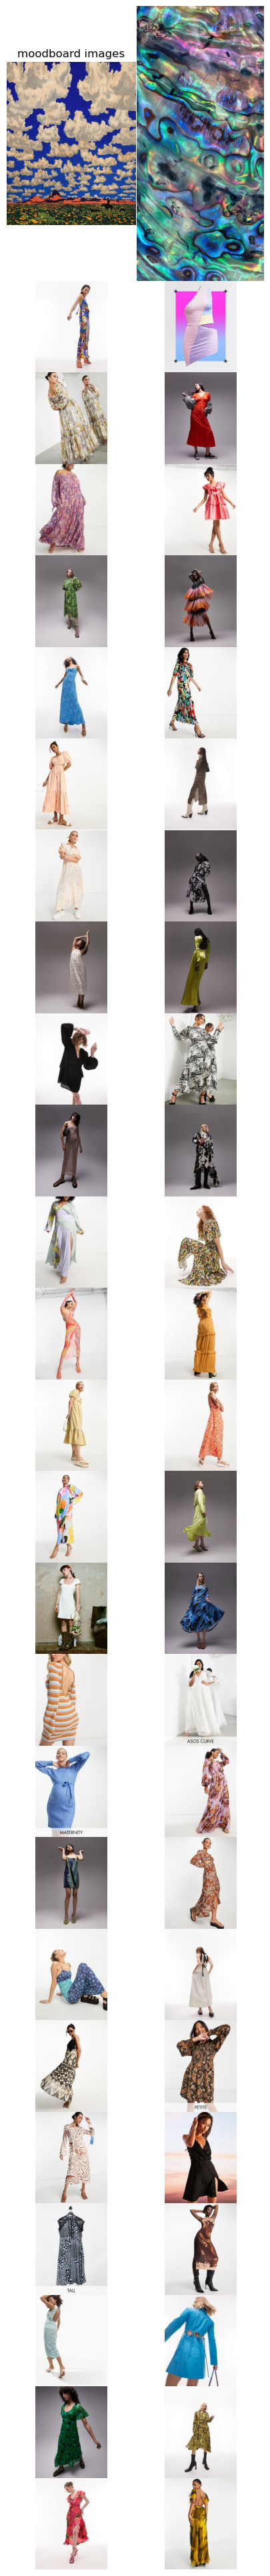

In [252]:
category_vembeds = candidate_vembeds
dim = category_vembeds.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(category_vembeds)

# get our query embeddings
# image_url1 = "https://i.pinimg.com/474x/53/37/d5/5337d5464816d2c405b80cb7283edaa9.jpg"
# image_url1 = "https://i.pinimg.com/474x/65/76/5d/65765da55a1c7043d13908e098d62814.jpg"

# image_url1 = "https://i.pinimg.com/474x/7c/c8/e3/7cc8e31cd06fca4e6aa5c9f1a550fe1b.jpg"
# image_url2 = "https://i.pinimg.com/474x/e3/7d/93/e37d93f00bb5773b2e3cf46d06ea01c7.jpg"

# image_url2 = "https://i.pinimg.com/564x/2a/da/f7/2adaf77f93508acd3e2d3448768be26b.jpg"
image_url2 = "https://i.pinimg.com/564x/6f/38/29/6f38294fdc3f59e20be41c7e66f0bcaf.jpg"
image_url1 = "https://i.pinimg.com/564x/25/2c/5c/252c5cb1b521c13a97045bc73add3751.jpg"
# image_url = "https://i.pinimg.com/564x/f9/9c/77/f99c77136c9b0af5eab79bfcbd414aed.jpg"
# image_url = "https://i.pinimg.com/564x/99/8c/14/998c14a26d8bedcf39c63265d332fa75.jpg"
k = 50


image1 = Image.open(requests.get(image_url1, stream=True).raw)
image2 = Image.open(requests.get(image_url2, stream=True).raw)

images = [image1, image2]
texts = ["a woman in a dress", "a catalog photo of a dress"]

wimages = [5., 0.]
wtexts = [0., 0.]

dists, idxs = search(images, texts, wimages, wtexts, index=index, k=k)

# plot
fig, axes = plt.subplots(1 + (k // 2), 2, 
                         figsize = (5, 50), 
                         gridspec_kw={'height_ratios': [3] + [1] * (k//2),})

for ax in axes.ravel():
    ax.axis("off")
    
axes[0, 0].imshow(image1)
axes[0, 1].imshow(image2)
axes[0, 0].set_title("moodboard images")

i, j = 1, 0
for idx in idxs[0]:
    ax = axes[i, j]
    ax.imshow(asos_dataset[idx][0])
    ax.set_aspect("equal")
    j += 1
    if j == 2:
        j = 0
        i += 1

plt.subplots_adjust(hspace=0.0, wspace = 0.0)
plt.show()